In [1]:
import torch_config as config
from data_functions import convert_to_tensor, load_data, split_data
from model.anomaly_detector import AnomalyDetector
from utils.gpu_utils import device_context
from matplotlib import pyplot as plt
import numpy as np
from skimage.filters.thresholding import threshold_otsu
from test import evaluate

/home/marco741/miniconda3/envs/torch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(GPU is available)
(Using Device: cpu)


In [2]:
dirpath = config.SAVED_MODEL_PATH
dirpath.mkdir(exist_ok=True, parents=True)

In [3]:
patient = "chb01"
patient_dirpath = dirpath/patient
X_normal, X_test = load_data(config.H5_FILEPATH, patient, preprocess=not config.USE_CONVOLUTION)
if not X_normal:
    raise ValueError("No training data found")
if not X_test:
    raise ValueError("No test data found")
_, X_val = split_data(X_normal, random_state=config.RANDOM_STATE)

# Convert to tensor
X_val, = convert_to_tensor(X_val)
X_test = convert_to_tensor(*X_test)

with device_context:
    model = AnomalyDetector.load(patient_dirpath)
    val_losses = model.model.calculate_losses(X_val).cpu().numpy()  # type: ignore
    test_losses = tuple(model.model.calculate_losses(x).cpu().numpy() for x in X_test)  # type: ignore

Loading training data...  DONE
Training recordings: 35
Total training samples: 24378
Loading test data...  DONE
Testing recordings: 7
Total testing samples: 2220
Splitting data...  DONE
(Using Device: cuda)
(Using Device: cpu)


IndexError: tuple index out of range

In [18]:
sep = config.PREICTAL_SECONDS//(config.WINDOW_SIZE_SECONDS - config.WINDOW_OVERLAP_SECONDS)
test_normal_losses = []
test_preictal_losses = []

for test_loss in test_losses:
    test_normal_losses.append(test_loss[:sep])
    test_preictal_losses.append(test_loss[sep:])

test_normal_losses = np.concatenate(test_normal_losses)
test_preictal_losses = np.concatenate(test_preictal_losses)

Text(0.5, 1.0, 'Test Preictal Losses')

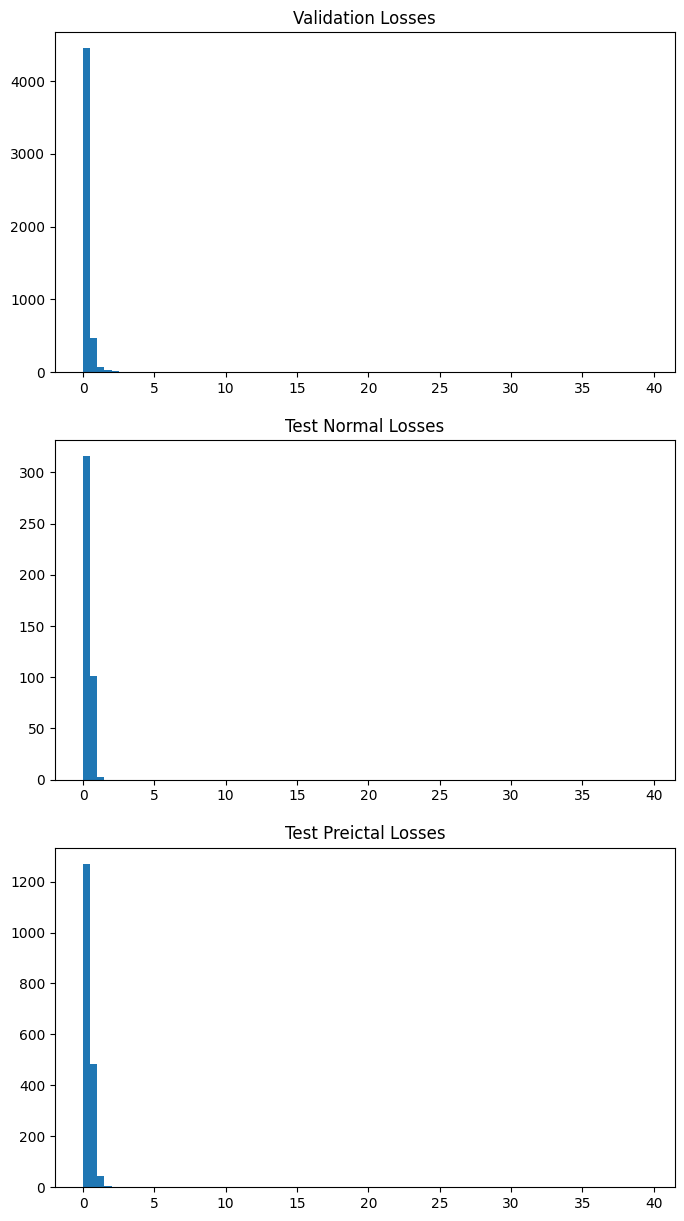

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15))
axs[0].hist(val_losses, bins=[x/2 for x in range(0, 80, 1)])
axs[0].set_title("Validation Losses")
axs[1].hist(test_normal_losses, bins=[x/2 for x in range(0, 80, 1)])
axs[1].set_title("Test Normal Losses")
axs[2].hist(test_preictal_losses, bins=[x/2 for x in range(0, 80, 1)])
axs[2].set_title("Test Preictal Losses")

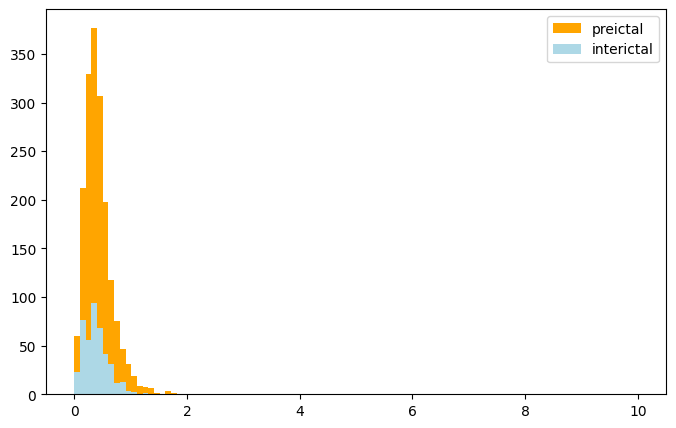

In [41]:
bins = np.linspace(0, 10, 100, True)
fig, ax = plt.subplots(figsize=(8, 5))
_ = ax.hist(test_preictal_losses, bins=bins, label="preictal")
_ = ax.hist(test_normal_losses, bins=bins, label="interictal")
_ = ax.legend()

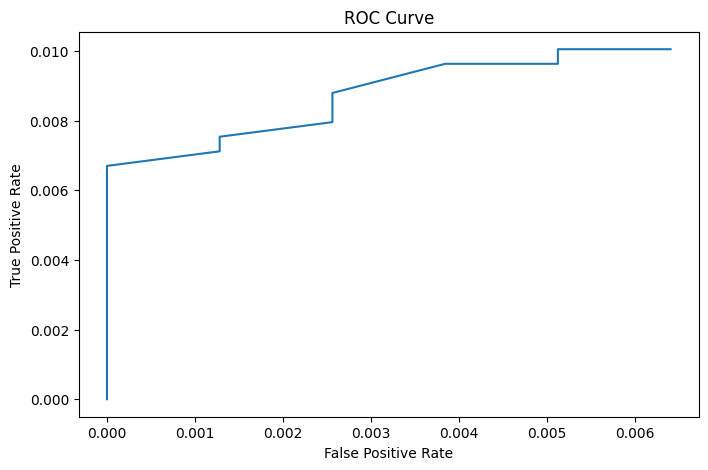

In [6]:
x = np.arange(98,100.1,0.1)
x = np.percentile(val_losses, x)
fp = np.array([np.count_nonzero(test_normal_losses > th)/len(test_normal_losses) for th in x])
tp = np.array([np.count_nonzero(test_preictal_losses > th)/len(test_preictal_losses) for th in x])
fn = 1 - tp
tn = 1 - fp 
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot(fpr, tpr)

In [7]:
# print([np.percentile(val_losses, x/10) for x in range(990, 1001, 1)])
perc = 90
print(np.percentile(val_losses, perc))
model.threshold.threshold = np.percentile(val_losses, perc)
# print("otsu:", threshold_otsu(val_losses))
# model.threshold.threshold = threshold_otsu(val_losses)
model.save(dirpath)

9.155703163146972


In [14]:
perc = 96.5
print(np.percentile(val_losses, perc))
model.threshold.threshold = np.percentile(val_losses, perc)
preds = tuple(model.predict(x).cpu().numpy() for x in X_test)
evaluate(preds)

13.14699203491211
Consecutive windows: 1
Accuracy: 0.231 (3 / 13)
Samples not found: 4 / 13
Average time left: 786.1111111111111 seconds

Consecutive windows: 2
Accuracy: 0.231 (3 / 13)
Samples not found: 4 / 13
Average time left: 791.1111111111111 seconds

Consecutive windows: 3
Accuracy: 0.000 (0 / 13)
Samples not found: 11 / 13
Average time left: 987.5 seconds

Consecutive windows: 4
Accuracy: 0.000 (0 / 13)
Samples not found: 10 / 13
Average time left: 833.3333333333334 seconds

Consecutive windows: 5
Accuracy: 0.000 (0 / 13)
Samples not found: 12 / 13
Average time left: 1160.0 seconds

Consecutive windows: 6
Accuracy: 0.000 (0 / 13)
Samples not found: 12 / 13
Average time left: 1160.0 seconds

Consecutive windows: 7
Accuracy: 0.000 (0 / 13)
Samples not found: 12 / 13
Average time left: 1150.0 seconds

Consecutive windows: 8
Accuracy: 0.000 (0 / 13)
Samples not found: 12 / 13
Average time left: 1150.0 seconds

Consecutive windows: 9
Accuracy: 0.000 (0 / 13)
Samples not found: 12 / 